![表紙](https://www.oreilly.co.jp/books/images/picture978-4-87311-907-6.gif)

このノートブックはオライリー・ジャパンより発行の書籍[『セキュリティエンジニアのための機械学習』](https://www.oreilly.co.jp/books/9784873119076/)のサンプルコードです。コードの解説等は書籍をご参照ください。なお、このコードを動作させた結果について、著者およびオライリー・ジャパンは一切の責任を負いません。

## ファイルのメタデータを特徴量にしたマルウェア検出



### 最初にpandas-profilingを更新して、ランタイムを再起動しておく

In [7]:
# !pip install -U pandas-profiling

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 262.6/262.6 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 72.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.4/102.4 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.8/309.8 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 687.8/687.8 kB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 76.8 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27081 sha256=73b4703bc72d28c76388f01b9cb4c090ab72f2c32f2f9004f493007fc5b3fbcd
  Stored in directory: /root/.cache/pip/wheels/8d/55/1a/19cd535375ed1ede0c996405ebffe34b196d78e2d9545723a2
Successfully built htmlmin
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.

In [2]:
!wget https://github.com/oreilly-japan/ml-security-jp/raw/master/ch03/MalwareData.csv.gz

--2025-04-08 09:07:12--  https://github.com/oreilly-japan/ml-security-jp/raw/master/ch03/MalwareData.csv.gz
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/oreilly-japan/ml-security-jp/master/ch03/MalwareData.csv.gz [following]
--2025-04-08 09:07:13--  https://raw.githubusercontent.com/oreilly-japan/ml-security-jp/master/ch03/MalwareData.csv.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11831806 (11M) [application/octet-stream]
Saving to: ‘MalwareData.csv.gz’

MalwareData.csv.gz  100%[===================>]  11.28M  --.-KB/s    in 0.1s    

2025-04-08 09:07:13 (110 MB/s) - ‘MalwareData.csv.g

In [3]:
!gzip -d MalwareData.csv.gz

gzip: MalwareData.csv already exists; do you wish to overwrite (y or n)? y


In [4]:
!pip install optuna

In [5]:
import pandas as pd
MalwareDataset = pd.read_csv('MalwareData.csv', sep='|')

In [6]:
MalwareDataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138047 entries, 0 to 138046
Data columns (total 57 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Name                         138047 non-null  object 
 1   md5                          138047 non-null  object 
 2   Machine                      138047 non-null  int64  
 3   SizeOfOptionalHeader         138047 non-null  int64  
 4   Characteristics              138047 non-null  int64  
 5   MajorLinkerVersion           138047 non-null  int64  
 6   MinorLinkerVersion           138047 non-null  int64  
 7   SizeOfCode                   138047 non-null  int64  
 8   SizeOfInitializedData        138047 non-null  int64  
 9   SizeOfUninitializedData      138047 non-null  int64  
 10  AddressOfEntryPoint          138047 non-null  int64  
 11  BaseOfCode                   138047 non-null  int64  
 12  BaseOfData                   138047 non-null  int64  
 13 

In [7]:
!pip install -U ydata-profiling

In [8]:

# import pandas_profiling
from ydata_profiling import ProfileReport

ProfileReport(MalwareDataset, minimal=True)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 57/57 [00:17<00:00,  3.26it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

(0.0, 26.0)

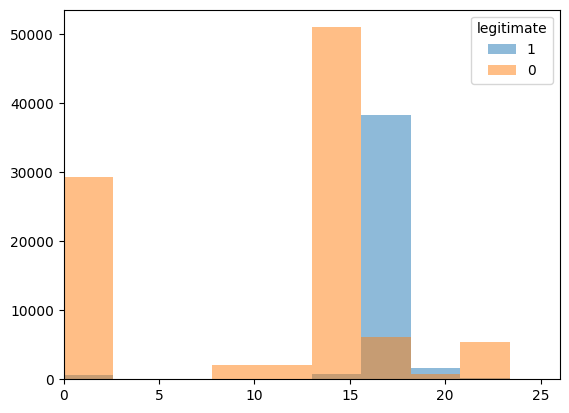

In [9]:
import matplotlib.pyplot as plt

plt.hist(
    MalwareDataset.loc[MalwareDataset['legitimate'] == 1,\
                       'VersionInformationSize'],
    range=(0,26), alpha=0.5, label='1'
    )
plt.hist(
    MalwareDataset.loc[MalwareDataset['legitimate'] == 0,\
                       'VersionInformationSize'],
    range=(0,26), alpha=0.5, label='0'
    )
plt.legend(title='legitimate')
plt.xlim(0,26)

(2.0, 11.0)

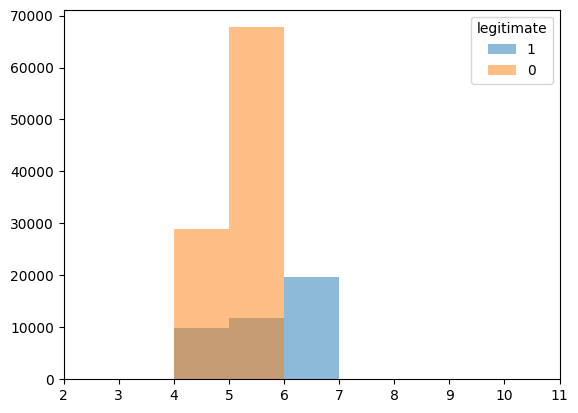

In [10]:
import matplotlib.pyplot as plt

plt.hist(
    MalwareDataset.loc[MalwareDataset['legitimate'] == 1,\
                            'MajorSubsystemVersion'],
         range=(0,10), alpha=0.5, label='1'
         )
plt.hist(
    MalwareDataset.loc[MalwareDataset['legitimate'] == 0,\
                            'MajorSubsystemVersion'],
         range=(0,10), alpha=0.5, label='0'
         )

plt.legend(title='legitimate')
plt.xlim(2,11)

(0.0, 10000.0)

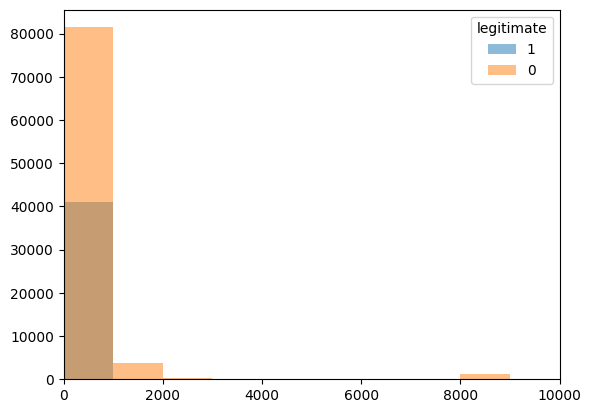

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.hist(MalwareDataset.loc[MalwareDataset['legitimate'] == 1, 'SizeOfUninitializedData'], range=(0,10000), alpha=0.5, label='1')
plt.hist(MalwareDataset.loc[MalwareDataset['legitimate'] == 0, 'SizeOfUninitializedData'], range=(0,10000), alpha=0.5, label='0')
plt.legend(title='legitimate')
plt.xlim(0,10000)

In [12]:
print('The Number of features are  {} \n'.format(MalwareDataset.shape[1]))

The Number of features are  57 



In [13]:
MalwareDataset.columns

Index(['Name', 'md5', 'Machine', 'SizeOfOptionalHeader', 'Characteristics',
       'MajorLinkerVersion', 'MinorLinkerVersion', 'SizeOfCode',
       'SizeOfInitializedData', 'SizeOfUninitializedData',
       'AddressOfEntryPoint', 'BaseOfCode', 'BaseOfData', 'ImageBase',
       'SectionAlignment', 'FileAlignment', 'MajorOperatingSystemVersion',
       'MinorOperatingSystemVersion', 'MajorImageVersion', 'MinorImageVersion',
       'MajorSubsystemVersion', 'MinorSubsystemVersion', 'SizeOfImage',
       'SizeOfHeaders', 'CheckSum', 'Subsystem', 'DllCharacteristics',
       'SizeOfStackReserve', 'SizeOfStackCommit', 'SizeOfHeapReserve',
       'SizeOfHeapCommit', 'LoaderFlags', 'NumberOfRvaAndSizes', 'SectionsNb',
       'SectionsMeanEntropy', 'SectionsMinEntropy', 'SectionsMaxEntropy',
       'SectionsMeanRawsize', 'SectionsMinRawsize', 'SectionMaxRawsize',
       'SectionsMeanVirtualsize', 'SectionsMinVirtualsize',
       'SectionMaxVirtualsize', 'ImportsNbDLL', 'ImportsNb',
       'Impor

In [15]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn import model_selection

# データセットから名前、md5ハッシュ値、ラベルといった列を除外してXに代入
X = MalwareDataset.drop(['Name', 'md5', 'legitimate'],axis='columns')
# データセットのラベル列のみを抽出してyに代入
y = MalwareDataset['legitimate']
# ExtraTreesClassifierを使用
FeatSelect=ExtraTreesClassifier().fit(X, y)
# SelectFromModelを使用して、
# ExtraTreesClassifierによる分類結果に寄与した重要度の大きい特徴量のみを抽出
Model = SelectFromModel(FeatSelect, prefit=True)
# 重要度の大きい特徴量のカラム名を取得
feature_idx = Model.get_support()
feature_name = X.columns[feature_idx]
# Xに選択した特徴量のみを代入しなおす
X = Model.transform(X)
# 重要度の大きい特徴量のカラム名を設定
X = pd.DataFrame(X)
X.columns = feature_name

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [16]:
Features = X.shape[1]
# 重要度をリストで抽出
FI = ExtraTreesClassifier().fit(X,y).feature_importances_
# 重要度を高い順にソート
Index = np.argsort(FI)[::-1][:Features]
# 重要度の高い順に、特徴量の名前と重要度を出力
for feat  in range(Features):
    print(
        "Feature: {}Importance: {:.5f}"\
          .format(MalwareDataset.columns[2+Index[feat]].ljust(30),
                  FI[Index[feat]])
          )

Feature: SizeOfUninitializedData       Importance: 0.16497
Feature: Machine                       Importance: 0.12484
Feature: Characteristics               Importance: 0.11594
Feature: SizeOfInitializedData         Importance: 0.08410
Feature: BaseOfData                    Importance: 0.07977
Feature: FileAlignment                 Importance: 0.07390
Feature: SizeOfCode                    Importance: 0.07297
Feature: MajorLinkerVersion            Importance: 0.06393
Feature: SectionAlignment              Importance: 0.05250
Feature: ImageBase                     Importance: 0.04847
Feature: SizeOfOptionalHeader          Importance: 0.03991
Feature: MinorLinkerVersion            Importance: 0.02926
Feature: BaseOfCode                    Importance: 0.02903
Feature: AddressOfEntryPoint           Importance: 0.02041


In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
import optuna
from sklearn.model_selection import cross_validate

# データセットを訓練用とテスト用に分割
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=101
    )

# RandomForestClassifierのハイパーパラメータ探索用のクラスを設定
class Objective_RF:
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __call__(self, trial):
        # 探索対象のパラメータの設定
        criterion = trial.suggest_categorical("criterion",
                                              ["gini", "entropy"])
        bootstrap = trial.suggest_categorical('bootstrap', [True, False])  # ← 修正ここ！
        max_features = trial.suggest_categorical('max_features',
                                            ['auto', 'sqrt','log2'])
        min_samples_split = trial.suggest_int('min_samples_split',
                                              2, 5)
        min_samples_leaf = trial.suggest_int('min_samples_leaf',
                                             1,10)

        model = RandomForestClassifier(
            criterion = criterion,
            bootstrap = bootstrap,
            max_features = max_features,
            min_samples_split = min_samples_split,
            min_samples_leaf = min_samples_leaf
        )

        # 交差検証しながらベストのパラメータ探索を行う
        scores = cross_validate(model,
                                X=self.X,
                                y=self.y,
                                cv=5,
                                n_jobs=-1)

        # 5分割で交差検証した正解率の平均値を返す
        return scores['test_score'].mean()

# 探索の対象クラスを設定
objective = Objective_RF(X_train, y_train)
study = optuna.create_study()
# 最大で3分間探索を実行
study.optimize(objective, timeout=180)
# ベストのパラメータの出力
print('params:', study.best_params)

ModuleNotFoundError: No module named 'optuna'

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# optunaの探索結果として得られたベストのパラメータを設定
model = RandomForestClassifier(
    criterion = study.best_params['criterion'],
    bootstrap = study.best_params['bootstrap'],
    max_features = study.best_params['max_features'],
    min_samples_split = study.best_params['min_samples_split'],
    min_samples_leaf = study.best_params['min_samples_leaf']
)

# モデルの訓練
model.fit(X_train, y_train)

# テスト用のデータを使用して予測
pred = model.predict(X_test)

# 予測結果とテスト用のデータを使って正解率と、混同行列を出力
print("Accuracy: {:.5f} %".format(100 * accuracy_score(y_test, pred)))
print(confusion_matrix(y_test, pred))

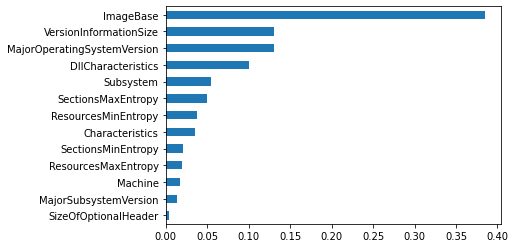

In [ ]:
%matplotlib inline

feat_importances = pd.Series(
    model.feature_importances_,
    index=X.columns).sort_values(ascending=True)

feat_importances.plot(kind='barh')

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

class Objective_GBC:
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __call__(self, trial):
        # 探索対象のパラメーターの指定
        max_depth=int(
            trial.suggest_loguniform("max_depth", 3, 10))
        max_features = trial.suggest_categorical(
            "max_features", ["log2", "sqrt"])
        learning_rate = float(trial.suggest_loguniform(
            "learning_rate", 1e-2, 1e-0))
        criterion =  trial.suggest_categorical(
            "criterion", ["friedman_mse", "mse", "mae"])

        # モデルの初期化
        model = GradientBoostingClassifier(
            max_depth = max_depth,
            max_features = max_features,
            learning_rate = learning_rate,
            criterion=criterion
            )

        scores = cross_validate(model,
                                X=self.X, y=self.y,
                                cv=5,
                                n_jobs=-1)
        return scores['test_score'].mean()

# 探索の対象クラスを設定
objective = Objective_GBC(X_test, y_test)
study = optuna.create_study()

# 1回のみ探索
study.optimize(objective, n_trials=1)

# ベストのパラメーターの出力
print('params:', study.best_params)

[I 2021-09-29 15:26:17,286] A new study created in memory with name: no-name-1f5e56c0-ea5e-4fda-866a-09c348c54d24
[I 2021-09-29 15:26:23,265] Trial 0 finished with value: 0.9885910901847158 and parameters: {'max_depth': 3.8840716547752936, 'max_features': 'log2', 'learning_rate': 0.09519414699832293, 'criterion': 'friedman_mse'}. Best is trial 0 with value: 0.9885910901847158.


params: {'max_depth': 3.8840716547752936, 'max_features': 'log2', 'learning_rate': 0.09519414699832293, 'criterion': 'friedman_mse'}


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# 探索結果として得られたベストのパラメーターを設定
model = GradientBoostingClassifier(
    criterion = study.best_params['criterion'],
    learning_rate = study.best_params['learning_rate'],
    max_depth = study.best_params['max_depth'],
    max_features = study.best_params['max_features']
)

# モデルの訓練
model.fit(X_train, y_train)

# テスト用のデータを使用して予測
pred = model.predict(X_test)

# 予測結果とテスト用のデータを使って正解率と、混同行列を出力
print("Accuracy: {:.5f} %".format(100 * accuracy_score(y_test, pred)))
print(confusion_matrix(y_test, pred))

Accuracy: 98.85187 %
[[19319   147]
 [  170  7974]]


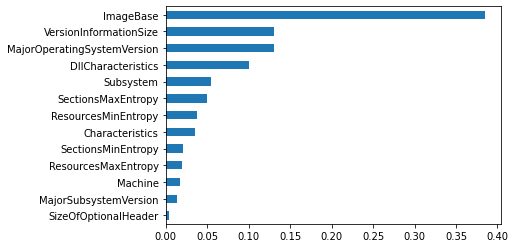

In [ ]:
feat_importances = pd.Series(
    model.feature_importances_,
    index=X.columns).sort_values(ascending=True)
feat_importances.plot(kind='barh')

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

class Objective_ABC:
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __call__(self, trial):
        # 探索対象のパラメーターの指定
        algorithm =  trial.suggest_categorical("algorithm", ["SAMME", "SAMME.R"])
        learning_rate = float(trial.suggest_loguniform("learning_rate", 1e-2, 1e-0))

        # モデルの初期化
        model = AdaBoostClassifier(
            algorithm = algorithm,
            learning_rate = learning_rate
            )

        scores = cross_validate(model,
                                X=self.X, y=self.y,
                                cv=5,
                                n_jobs=-1)
        return scores['test_score'].mean()

# 探索の対象クラスを設定
objective = Objective_ABC(X_train, y_train)
study = optuna.create_study()

# 最大で1分間探索を実行
study.optimize(objective, timeout=60)

# ベストのパラメーターの出力
print('params:', study.best_params)

[I 2021-09-29 15:26:29,865] A new study created in memory with name: no-name-67e7ffcb-bdd9-4c64-84de-09e9c39548ce
[I 2021-09-29 15:26:46,213] Trial 0 finished with value: 0.9843349540465139 and parameters: {'algorithm': 'SAMME.R', 'learning_rate': 0.2063479898087131}. Best is trial 0 with value: 0.9843349540465139.
[I 2021-09-29 15:26:59,439] Trial 1 finished with value: 0.9733150224458095 and parameters: {'algorithm': 'SAMME', 'learning_rate': 0.04112676151726043}. Best is trial 1 with value: 0.9733150224458095.
[I 2021-09-29 15:27:15,572] Trial 2 finished with value: 0.9847605273616942 and parameters: {'algorithm': 'SAMME.R', 'learning_rate': 0.3042562063378616}. Best is trial 1 with value: 0.9733150224458095.
[I 2021-09-29 15:27:28,786] Trial 3 finished with value: 0.9550059880581232 and parameters: {'algorithm': 'SAMME', 'learning_rate': 0.022017541860529316}. Best is trial 3 with value: 0.9550059880581232.


KeyboardInterrupt: ignored

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# 探索結果として得られたベストのパラメーターを設定
model = AdaBoostClassifier(
    algorithm = study.best_params['algorithm'],
    learning_rate = study.best_params['learning_rate']
)
# モデルの訓練
model.fit(X_train, y_train)

# テスト用のデータを使用して予測
pred = model.predict(X_test)

# 予測結果とテスト用のデータを使って正解率と、混同行列を出力
print("Accuracy: {:.5f} %".format(100 * accuracy_score(y_test, pred)))
print(confusion_matrix(y_test, pred))

In [ ]:
feat_importances = pd.Series(
    model.feature_importances_,
    index=X.columns).sort_values(ascending=True)

feat_importances.plot(kind='barh')

## Androidマルウェアのデータセットを使用した検出デモ

This dataset created & provided by following paper:
Urcuqui, C., & Navarro, A. (2016, April). Machine learning classifiers for android malware analysis. In Communications and Computing (COLCOM), 2016 IEEE Colombian Conference on (pp. 1-6). IEEE.

In [ ]:
!wget https://github.com/oreilly-japan/ml-security-jp/raw/master/ch03/archive.zip

--2021-09-29 15:32:53--  https://github.com/oreilly-japan/ml-security-jp/raw/master/ch03/archive.zip
Resolving github.com (github.com)... 52.69.186.44
Connecting to github.com (github.com)|52.69.186.44|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/oreilly-japan/ml-security-jp/master/ch03/archive.zip [following]
--2021-09-29 15:32:54--  https://raw.githubusercontent.com/oreilly-japan/ml-security-jp/master/ch03/archive.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9246 (9.0K) [application/zip]
Saving to: ‘archive.zip’

archive.zip         100%[===================>]   9.03K  --.-KB/s    in 0s      

2021-09-29 15:32:54 (71.9 MB/s) - ‘archive.zip’ saved [9246/9246]



In [ ]:
!unzip -q archive.zip

In [ ]:
import pandas as pd

# データセットのロード
AndroidDataset = pd.read_csv('train.csv', sep=';')

In [ ]:
AndroidDataset.type.value_counts()

1    199
0    199
Name: type, dtype: int64

In [ ]:
print(AndroidDataset.columns)

Index(['android', 'android.app.cts.permission.TEST_GRANTED',
       'android.intent.category.MASTER_CLEAR.permission.C2D_MESSAGE',
       'android.os.cts.permission.TEST_GRANTED',
       'android.permission.ACCESS_ALL_DOWNLOADS',
       'android.permission.ACCESS_ALL_EXTERNAL_STORAGE',
       'android.permission.ACCESS_BLUETOOTH_SHARE',
       'android.permission.ACCESS_CACHE_FILESYSTEM',
       'android.permission.ACCESS_CHECKIN_PROPERTIES',
       'android.permission.ACCESS_COARSE_LOCATION',
       ...
       'com.android.voicemail.permission.WRITE_VOICEMAIL',
       'com.foo.mypermission', 'com.foo.mypermission2',
       'org.chromium.chrome.shell.permission.C2D_MESSAGE',
       'org.chromium.chrome.shell.permission.DEBUG',
       'org.chromium.chrome.shell.permission.SANDBOX',
       'org.chromium.chromecast.shell.permission.SANDBOX',
       'org.chromium.content_shell.permission.SANDBOX', 'test_permission',
       'type'],
      dtype='object', length=331)


In [ ]:
pd.Series.sort_values(
    AndroidDataset[AndroidDataset.type==1].sum(axis=0),
    ascending=False
    )[1:11]

android.permission.INTERNET                  195
android.permission.READ_PHONE_STATE          190
android.permission.ACCESS_NETWORK_STATE      167
android.permission.WRITE_EXTERNAL_STORAGE    136
android.permission.ACCESS_WIFI_STATE         135
android.permission.READ_SMS                  124
android.permission.WRITE_SMS                 104
android.permission.RECEIVE_BOOT_COMPLETED    102
android.permission.ACCESS_COARSE_LOCATION     80
android.permission.CHANGE_WIFI_STATE          75
dtype: int64

In [ ]:
top10 = ['android.permission.INTERNET',
         'android.permission.READ_PHONE_STATE',
         'android.permission.ACCESS_NETWORK_STATE',
         'android.permission.WRITE_EXTERNAL_STORAGE',
         'android.permission.ACCESS_WIFI_STATE',
         'android.permission.READ_SMS',
         'android.permission.WRITE_SMS',
         'android.permission.RECEIVE_BOOT_COMPLETED',
         'android.permission.ACCESS_COARSE_LOCATION',
         'android.permission.CHANGE_WIFI_STATE']

In [ ]:
AndroidDataset.loc[AndroidDataset.type==1, top10].sum()

android.permission.INTERNET                  195
android.permission.READ_PHONE_STATE          190
android.permission.ACCESS_NETWORK_STATE      167
android.permission.WRITE_EXTERNAL_STORAGE    136
android.permission.ACCESS_WIFI_STATE         135
android.permission.READ_SMS                  124
android.permission.WRITE_SMS                 104
android.permission.RECEIVE_BOOT_COMPLETED    102
android.permission.ACCESS_COARSE_LOCATION     80
android.permission.CHANGE_WIFI_STATE          75
dtype: int64

In [ ]:
AndroidDataset.loc[AndroidDataset.type==0, top10].sum()

android.permission.INTERNET                  104
android.permission.READ_PHONE_STATE           24
android.permission.ACCESS_NETWORK_STATE       62
android.permission.WRITE_EXTERNAL_STORAGE     76
android.permission.ACCESS_WIFI_STATE          29
android.permission.READ_SMS                    4
android.permission.WRITE_SMS                   1
android.permission.RECEIVE_BOOT_COMPLETED     30
android.permission.ACCESS_COARSE_LOCATION     13
android.permission.CHANGE_WIFI_STATE          13
dtype: int64

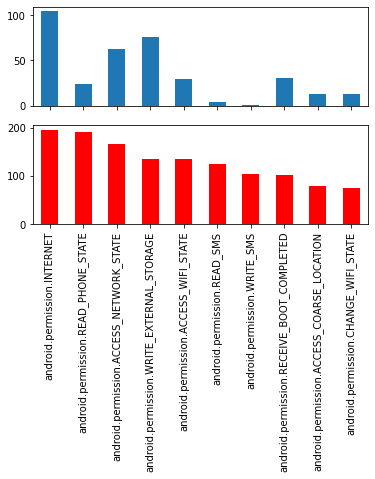

In [ ]:
import matplotlib.pyplot as plt
fig, axs =  plt.subplots(nrows=2, sharex=True)

AndroidDataset.loc[AndroidDataset.type==0, top10].sum().plot.bar(ax=axs[0])
AndroidDataset.loc[AndroidDataset.type==1, top10].sum().plot.bar(ax=axs[1], color="red")

In [ ]:
from sklearn.feature_selection import mutual_info_classif
from sklearn import preprocessing
import numpy as np
import pandas as pd
from sklearn.svm import SVC, LinearSVC
from sklearn import svm
import csv
import random

In [ ]:
# X,yに特徴量とラベルをそれぞれ代入
X = AndroidDataset.iloc[:,:-1]
y = AndroidDataset.iloc[:, -1]

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
import optuna
from sklearn.model_selection import StratifiedKFold, cross_validate

# データセットをテスト用のデータに20%を割り当てて分割
X_train, X_test, y_train, y_test = \
train_test_split(X, y, test_size=0.2, shuffle=True, random_state=101)

# SVMのハイパーパラメータチューニング用のクラスを設定
class Objective_SVM:
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __call__(self, trial):
        # チューニング対象のパラメーターを指定
        params = {
            'kernel': trial.suggest_categorical(
                'kernel', ['linear', 'poly', 'rbf', 'sigmoid']),
            'C': trial.suggest_loguniform('C', 1e-5, 1e2),
            'gamma': trial.suggest_categorical(
                'gamma', ['scale','auto']),
        }
        # モデルの初期化
        model = SVC(**params)

        scores = cross_validate(model,
                                X=self.X, y=self.y,
                                n_jobs=-1)
        return scores['test_score'].mean()

# チューニングの対象クラスを設定
objective = Objective_SVM(X_train, y_train)
study = optuna.create_study(direction='maximize')
# 最大で1分間チューニングを実行
study.optimize(objective, timeout=60)
# ベストのパラメーターの出力
print('params:', study.best_params)

[I 2021-09-29 15:33:02,806] A new study created in memory with name: no-name-8b60f039-41ef-4c35-9d24-14253b92657f
[I 2021-09-29 15:33:04,298] Trial 0 finished with value: 0.5062996031746032 and parameters: {'kernel': 'poly', 'C': 5.6168649851859085, 'gamma': 'auto'}. Best is trial 0 with value: 0.5062996031746032.
[I 2021-09-29 15:33:04,506] Trial 1 finished with value: 0.5062996031746032 and parameters: {'kernel': 'rbf', 'C': 0.0023532541970273935, 'gamma': 'scale'}. Best is trial 0 with value: 0.5062996031746032.
[I 2021-09-29 15:33:04,694] Trial 2 finished with value: 0.5062996031746032 and parameters: {'kernel': 'poly', 'C': 47.26494722591585, 'gamma': 'auto'}. Best is trial 0 with value: 0.5062996031746032.
[I 2021-09-29 15:33:04,885] Trial 3 finished with value: 0.6069444444444445 and parameters: {'kernel': 'poly', 'C': 0.004838912473818272, 'gamma': 'scale'}. Best is trial 3 with value: 0.6069444444444445.
[I 2021-09-29 15:33:05,074] Trial 4 finished with value: 0.50629960317460

params: {'kernel': 'linear', 'C': 4.3460405530919175, 'gamma': 'auto'}


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# 探索結果として得られたベストのパラメーターを設定

model = SVC(
    kernel = study.best_params['kernel'],
    C = study.best_params['C'],
    gamma = study.best_params['gamma']
)
# モデルの訓練
model.fit(X_train, y_train)
# テスト用のデータを使用して予測
pred = model.predict(X_test)
# 予測結果とテスト用のデータを使って正解率と、混同行列を出力
print("Accuracy: {:.5f} %".format(100 * accuracy_score(y_test, pred)))
print(confusion_matrix(y_test, pred))

Accuracy: 87.50000 %
[[33  5]
 [ 5 37]]
